In [51]:
import pandas as pd
import geopandas as gpd
import pycountry
from fuzzywuzzy import process

c:\Users\gabriel.genelot\AppData\Local\Programs\Python\Python312\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
wiliam = pd.read_csv('WILIAM_regions.csv')
wiliam['Regions'] = wiliam['Regions'].str.strip()
wiliam

,Regions,WILIAM
0,Austria,AUSTRIA
1,Belgium,BELGIUM
2,Bulgaria,BULGARIA
3,Croatia,CROATIA
4,Cyprus,CYPRUS
5,Czechia,CZECHIA
6,Denmark,DENMARK
7,Estonia,ESTONIA
8,Finland,FINLAND
9,France,FRANCE


In [58]:
rows_with_na = fund_exploded[fund_exploded['ISO'].isna()]
mismatch = rows_with_na['Countries'].values

all_country_names = [country.name for country in pycountry.countries]

def get_best_match(country_name):
    best_match, score = process.extractOne(country_name, all_country_names)
    return best_match if score > 80 else None

# Get the ISO codes for the non-matching countries
fuzzy_matches = {country: get_iso_code(get_best_match(country)) for country in mismatch}

fuzzy_matches

{'FYR Macedonia': None,
 'Yugoslavia': 'LVA',
 'Turkey': None,
 'West Bank and Gaza': 'BES',
 'Brunei': 'BRN',
 'East Timor': 'TLS',
 'Macau': None,
 'Cape Verde': None,
 'Congo-Brazzaville': 'COG',
 'Congo-Kinshasa': 'COG',
 'Cote d’Ivoire': 'CIV',
 'Guinea- Bissau': 'GNB',
 'Swaziland': None,
 'Micronesia': 'FSM',
 'Netherlands Antilles': 'NLD',
 'Reunion': 'REU',
 'St Kitts and Nevis': 'KNA',
 'St Lucia': 'LCA',
 'St Vincent and Grenadines': 'VCT',
 'Virgin Islands': 'VIR'}

In [110]:

def get_iso_code(country_name):
    if country_name == 'Russia':
        country_name = 'Russian Federation'
    elif country_name == 'Turkey':
        country_name = 'Türkiye'
    elif country_name == 'Congo-Kinshasa':
        country_name = 'Congo, The Democratic Republic of the'
    elif country_name == 'Congo-Brazzaville':
        country_name = 'Congo'
    elif country_name == 'Swaziland':
        country_name = 'Eswatini'

    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None
    
def get_iso_code_fuzzy(country_name):

    try:
        return pycountry.countries.lookup(get_best_match(country_name)).alpha_3
    except LookupError:
        return None


fund_exploded['ISO'] = fund_exploded['Countries'].apply(get_iso_code)
fund_exploded['ISO'] = fund_exploded['ISO'].fillna(fund_exploded['Countries'].apply(get_iso_code_fuzzy))
fund_exploded

,Code,Name,Countries,ISO
0,USA,USA,United States of America,USA
1,CAN,Canada,Canada,CAN
2,WEU,Western Europe,Andorra,AND
2,WEU,Western Europe,Austria,AUT
2,WEU,Western Europe,Belgium,BEL
...,...,...,...,...
15,SIS,Small Island States,Tonga,TON
15,SIS,Small Island States,Trinidad and Tobago,TTO
15,SIS,Small Island States,Tuvalu,TUV
15,SIS,Small Island States,Vanuatu,VUT


In [113]:
correspondance = wiliam.merge(fund_exploded, left_on='Regions', right_on='Countries', how='outer')
correspondance = correspondance.rename(columns={'Code': 'Region_FUND_code', 
                                                'Name': 'Region_FUND_name', 
                                                'WILIAM': 'Region_WILIAM'})
correspondance = correspondance.drop(columns=['Regions'])
correspondance.to_csv('correspondance.csv', index=False)
correspondance

,Region_WILIAM,Region_FUND_code,Region_FUND_name,Countries,ISO
0,NaN,SAS,South Asia,Afghanistan,AFG
1,NaN,CEE,Central and Eastern Europe,Albania,ALB
2,NaN,NAF,North Africa,Algeria,DZA
3,NaN,WEU,Western Europe,Andorra,AND
4,NaN,SSA,Sub-Saharan Africa,Angola,AGO
...,...,...,...,...,...
211,NaN,NAF,North Africa,Western Sahara,ESH
212,NaN,MDE,Middle East,Yemen,YEM
213,NaN,CEE,Central and Eastern Europe,Yugoslavia,LVA
214,NaN,SSA,Sub-Saharan Africa,Zambia,ZMB


<Axes: >

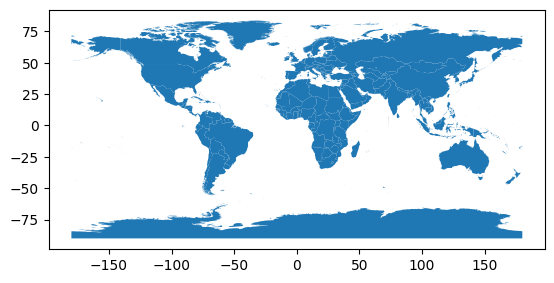

In [22]:
countries = gpd.read_file(r'naturalearthdata\ne_10m_admin_0_countries.shp')
countries.plot()

<Axes: >

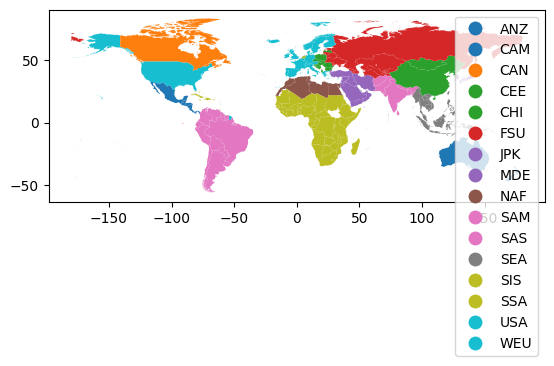

In [116]:
map = countries.merge(correspondance, left_on='ADM0_A3', right_on='ISO', how='left') 
map.plot(column='Region_FUND_code', legend=True)

In [79]:

vide = (fund_spatial['ISO'].isna() & fund_spatial['Name'].notna())
vide.value_counts()

False    260
Name: count, dtype: int64

In [117]:
# Assuming you have a GeoDataFrame named 'geodataframe'
map.to_file('output_countries/countries.shp', driver='ESRI Shapefile')

C:\Users\gabriel.genelot\AppData\Local\Temp\ipykernel_8136\3756580508.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  map.to_file('output_countries/countries.shp', driver='ESRI Shapefile')
